Scope acquisition
=================

.. Note::
        A version of this tutorial suitable for RF modules can be found [here](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/tutorials/q1asm_tutorials/basic/rf/scope_acquisition.html).

The QRM/QRM-RF instruments have high speed analog to digital capability for performing measurements. In this tutorial we will demonstrate the sequencer based scope acquisition procedure allowing you to inspect and process the raw input
of the QRM. We will also have a look at how to average multiple scope acquisitions in hardware (see section [Acquisition](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/cluster/q1_sequence_processor.html#acquisitions)). We will show this by using a QRM and directly connecting outputs 
$\text{O}^{[1-2]}$ to inputs $\text{I}^{[1-2]}$ respectively. We will then use the QRM's sequencers to sequence waveforms on 
the outputs and simultaneously acquire the resulting waveforms on the inputs. As this tutorial uses waveform generation and acquisition, it will cover usage of `waveforms` and `acquisitions` in the sequence.

As with all operations with QxM instruments, the devices will be controlled by preparing and uploading sequences onto the Q1 processors. 
For more info on the features, programming and operation of Q1 sequence processor please view [Q1 Sequencer](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/cluster/q1_sequence_processor.html).

To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```

Setup
-----

First, we are going to import the required packages.

In [97]:
# Import ipython widgets
import json
import math
import os

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

# Set up the environment.
import scipy.signal
from IPython.display import display
from ipywidgets import fixed, interact, interact_manual, interactive
from qcodes import Instrument
from qblox_instruments import Cluster, PlugAndPlay

### Scan For Clusters

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/tools.html#api-pnp) for more info).

In [98]:
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()

# Scan for available devices and display
names = {dev_id: dev_info["description"]["name"] for dev_id, dev_info in device_list.items()}
ip_addresses = {dev_id: dev_info["identity"]["ip"] for dev_id, dev_info in device_list.items()}

# create widget for names and ip addresses
connect = widgets.Dropdown(
    options=[
        (names[dev_id] + " @" + ip_addresses[dev_id], dev_id) for dev_id in device_list.keys()
    ],
    description="Select Device",
)
display(connect)

Dropdown(description='Select Device', options=(('Marketing-Cluster @192.168.1.170', '00015_2247_002'),), value…

### Connect to Cluster

We now make a connection with the Cluster selected in the dropdown widget. We also define a function to find the modules we're interested in. We select the readout and control module we want to use.

In [99]:
# Connect to device
dev_id = connect.value
# Close the chosen QCodes instrument as to prevent name clash.

# PlugAndPlay assigns an instrument name with a hyphen. For example 'pulsar-qrm' as a string for instrument name.
# QCodes instrument class cannot handle hyphens, and changes them to underscore '_'.
# However, this happens only once with a warning and never again, so code does not work. This line does the automation for it.
names[dev_id] = names[dev_id].replace("-", "_")

try:
    Instrument.find_instrument(names[dev_id]).close()
except KeyError:
    pass

cluster = Cluster(name=names[dev_id], identifier=ip_addresses[dev_id])

print(f"{connect.label} connected")
print(cluster.get_system_state())

Marketing-Cluster @192.168.1.170 connected
Status: OKAY, Flags: NONE, Slot flags: NONE


In [100]:
def select_module_widget(
    device, select_all=False, select_qrm_type: bool = True, select_rf_type: bool = False
):
    """Create a widget to select modules of a certain type

    default is to show only QRM baseband

    Args:
        devices : Cluster we are currently using
        select_all (bool): ignore filters and show all modules
        select_qrm_type (bool): filter QRM/QCM
        select_rf_type (bool): filter RF/baseband
    """
    options = [[None, None]]

    for module in device.modules:
        if module.present():
            if select_all or (
                module.is_qrm_type == select_qrm_type and module.is_rf_type == select_rf_type
            ):
                options.append(
                    [
                        f"{device.name} "
                        f"{module.short_name} "
                        f"({module.module_type}{'_RF' if module.is_rf_type else ''})",
                        module,
                    ]
                )
    widget = widgets.Dropdown(options=options)
    display(widget)

    return widget

In [104]:
print("Select the readout module from the available modules:")
select_qrm = select_module_widget(cluster, select_qrm_type=True, select_rf_type=True)

Select the readout module from the available modules:


Dropdown(options=([None, None], ['Marketing_Cluster module8 (QRM_RF)', <QcmQrm: Marketing_Cluster_module8 of C…

In [105]:
readout_module = select_qrm.value
print(f"{readout_module} connected")

<QcmQrm: Marketing_Cluster_module8 of Cluster: Marketing_Cluster> connected


In [106]:
print(readout_module.present())

True


In [107]:
readout_module.out0_in0_lo_en(True)

In [108]:
print(readout_module.out0_in0_lo_en())

True


In [109]:
print(readout_module.out0_in0_lo_freq())

6000000000


In [138]:
print(readout_module.in0_att())
print(readout_module.out0_att())
print(readout_module.in0_offset_path0())
print(readout_module.in0_offset_path1())
readout_module.out0_offset_path0(0)
readout_module.out0_offset_path1(0)
print(readout_module.out0_offset_path0())
print(readout_module.out0_offset_path1())

0
0
0.0
0.0
0.0
0.0


Generate waveforms <a id='gen_wf'></a>
------------------

Next, we need to create the gaussian and block waveforms for the sequence.

In [170]:
# Waveform parameters
waveform_length = 120  # nanoseconds

# Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {

#    "sine1": {
#        "data": [math.sin((4 * math.pi / waveform_length) * i) for i in range(0, waveform_length)],
#        "index": 0,
#    },

    "gaussian": {
        "data": scipy.signal.windows.gaussian(waveform_length, std=0.05 * waveform_length).tolist(),
        "index": 0,
    },

#    "sine": {
#        "data": [math.sin((2 * math.pi / waveform_length) * i) for i in range(0, waveform_length)],
#        "index": 1,
#    },

    "none": {
        "data": [0.0 for i in range(0, waveform_length)],
        "index": 1,
    },
}

Let's plot the waveforms to see what we have created.

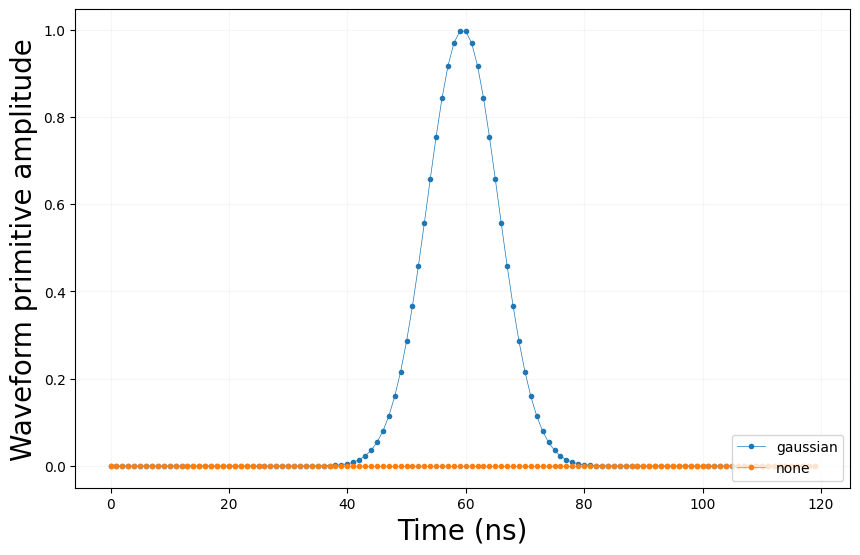

In [171]:
time = np.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.grid(alpha=1 / 10)
ax.set_ylabel("Waveform primitive amplitude", fontsize=20)
ax.set_xlabel("Time (ns)", fontsize=20)

plt.draw()
plt.show()

Specify acquisitions
--------------------

We also need to specify the acquisitions so that the instrument can allocate the required memory for it's acquisition list. In this case we will create 5 acquisition specifications that
each create a single bin. However, we will not be using the bins in this tutorial.

In [172]:
# Acquisitions
acquisitions = {
    "single": {"num_bins": 1, "index": 0},
    "multiple_0": {"num_bins": 1, "index": 1},
    "multiple_1": {"num_bins": 1, "index": 2},
    "multiple_2": {"num_bins": 1, "index": 3},
    "avg": {"num_bins": 1, "index": 4},
}

Create Q1ASM program
--------------------

Now that we have the waveforms and acquisitions specification for the sequence, we need a simple Q1ASM program that sequences and acquires the waveforms.
For a reference of available commands with Q1ASM please visit [Q1 Sequencer](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/cluster/q1_sequence_processor.html). Note how the Q1ASM references the JSON structures stored in the JSON file

In [173]:
# Sequence program.
seq_prog = """
play    0,1,4     #Play waveforms and wait 4ns. Parameters: waveform index (from dict) on path 0, waveform index (from dict) on path 1, wait (in ns) 
acquire 0,0,16380 #Acquire waveforms and wait remaining duration of scope acquisition. Parameters: acquisition index (from dict), data bin, Duration of acq (in ns)
stop              #Stop.
"""

Create and Upload sequence
--------------------------

Now that we have the waveform and acquisition specifications and Q1ASM program, we can combine them in a sequence stored in a JSON file.

In [174]:
# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0, which will drive outputs $\text{O}^{[1-2]}$ and acquire on inputs $\text{I}^{[1-2]}$.

In [175]:
# Upload sequence.
readout_module.sequencer0.sequence("sequence.json")

Play sequence
-------------

The sequence has been uploaded to the instrument. Now we need to configure the sequencers to trigger the acquisition with the `acquire` instruction.

In [176]:
# Configure the sequencer to trigger the scope acquisition.
readout_module.scope_acq_sequencer_select(0)
readout_module.scope_acq_trigger_mode_path0("sequencer")
readout_module.scope_acq_trigger_mode_path1("sequencer")

# Map sequencer to specific outputs (but first disable all sequencer connections)
readout_module.disconnect_outputs()
readout_module.disconnect_inputs()
for seq in readout_module.sequencers:
    seq.connect_sequencer("io0")

Now let's start the sequence.

In [177]:
# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Print status of sequencer.
print("Status:")
print(readout_module.get_sequencer_state(0))

Status:
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


Retrieve acquisition
--------------------

The waveforms have now been sequenced on the outputs and acquired on the inputs. Lets make sure that the sequencer has finished it's acquisition and then retrieve the
resulting data. The acquisition data is stored in a temporary memory in the instrument's FPGA. We need to first move the data from this memory into the into the
instrument's acquisition list. From there we can retrieve it from the instrument.

In [178]:
# Wait for the acquisition to finish with a timeout period of one minute.
readout_module.get_acquisition_state(0, 1)

# Move acquisition data from temporary memory to acquisition list.
readout_module.store_scope_acquisition(0, "single")

# Get acquisition list from instrument.
single_acq = readout_module.get_acquisitions(0)

Let's plot the result.

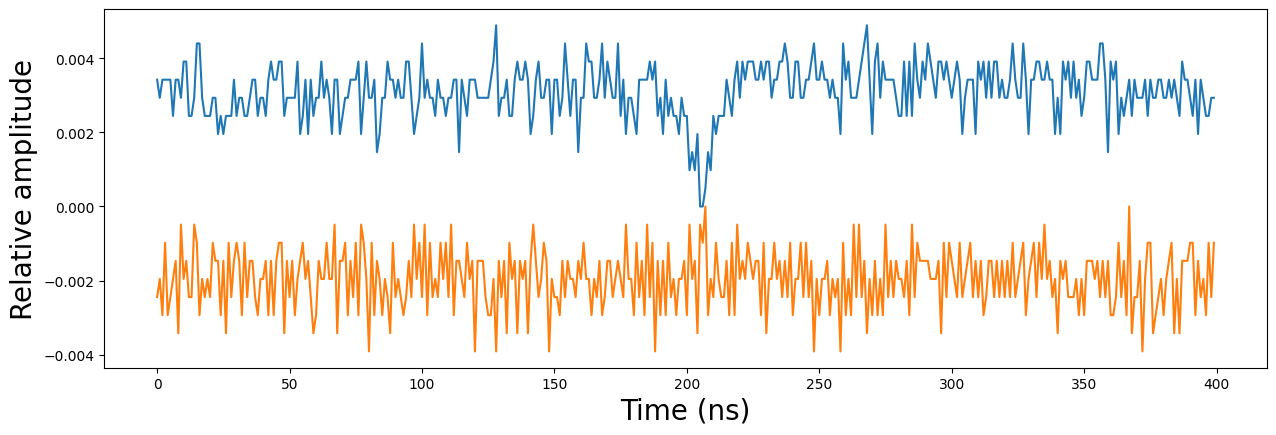

In [179]:
# Plot acquired signal on both inputs.
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(single_acq["single"]["acquisition"]["scope"]["path0"]["data"][0:400])
ax.plot(single_acq["single"]["acquisition"]["scope"]["path1"]["data"][0:400])
ax.set_xlabel("Time (ns)", fontsize=20)
ax.set_ylabel("Relative amplitude", fontsize=20)
plt.show()

Retrieve multiple acquisitions
------------------------------

We can also run the sequence multiple times consecutively and store the acquisition data in the instrument's acquisition list before retrieving them all in
one go. To demonstrate this we will run the same sequence three times and vary the output gain for each run to create a clear distinction between the acquisitions.

In [180]:
# First run
readout_module.sequencer0.gain_awg_path0(0.33)
readout_module.sequencer0.gain_awg_path1(0.33)

readout_module.arm_sequencer(0)
readout_module.start_sequencer()

readout_module.get_acquisition_state(0, 1)

readout_module.store_scope_acquisition(0, "multiple_0")

# Second run
readout_module.sequencer0.gain_awg_path0(0.66)
readout_module.sequencer0.gain_awg_path1(0.66)

readout_module.arm_sequencer(0)
readout_module.start_sequencer()

readout_module.get_acquisition_state(0, 1)

readout_module.store_scope_acquisition(0, "multiple_1")

# Third run
readout_module.sequencer0.gain_awg_path0(1)
readout_module.sequencer0.gain_awg_path1(1)

readout_module.arm_sequencer(0)
readout_module.start_sequencer()

readout_module.get_acquisition_state(0, 1)

readout_module.store_scope_acquisition(0, "multiple_2")

# Get acquisition list from instrument.
multiple_acq = readout_module.get_acquisitions(0)

Let's plot the result again.

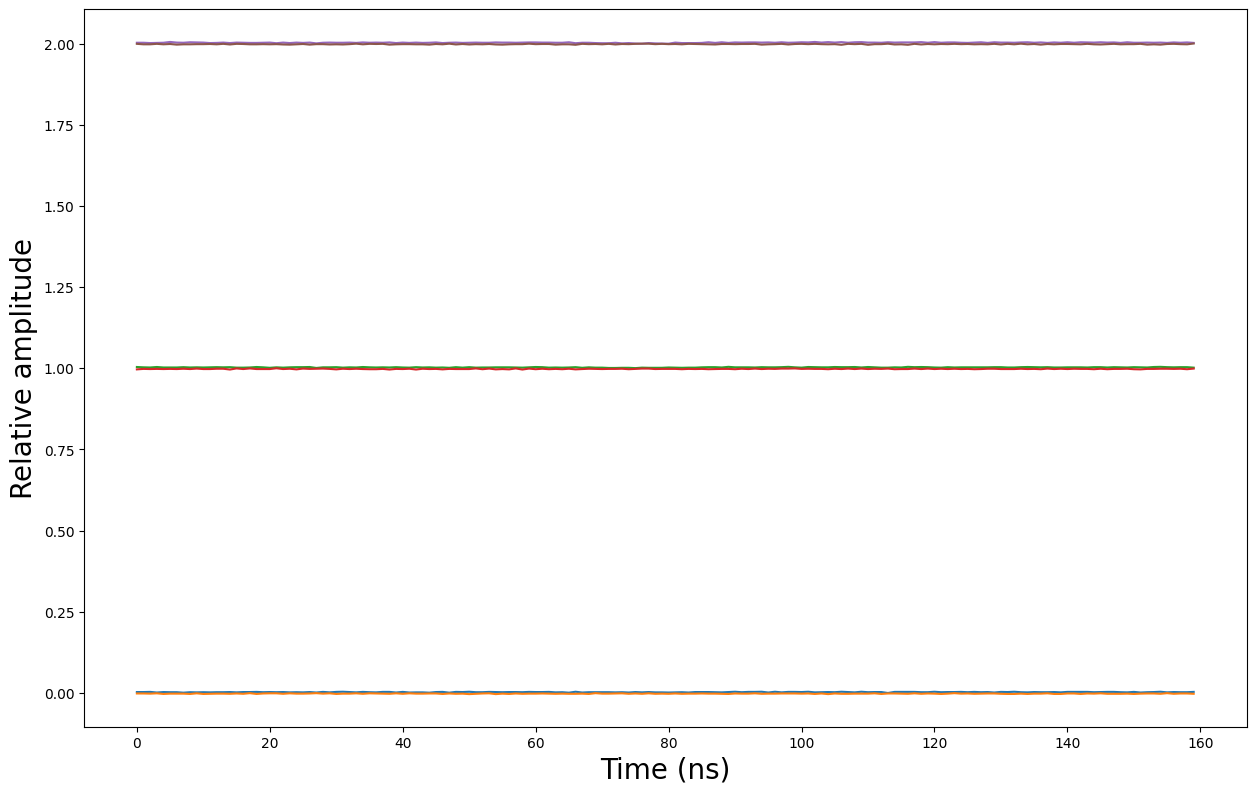

In [181]:
# Plot acquired signals (add acquisition index to separate acquisitions in plot).
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 1.61))
for acq_idx in range(0, 3):
    ax.plot(
        np.array(
            multiple_acq["multiple_{}".format(acq_idx)]["acquisition"]["scope"]["path0"]["data"][
                130:290
            ]
        )
        + acq_idx
    )
    ax.plot(
        np.array(
            multiple_acq["multiple_{}".format(acq_idx)]["acquisition"]["scope"]["path1"]["data"][
                130:290
            ]
        )
        + acq_idx
    )
    ax.set_xlabel("Time (ns)", fontsize=20)
    ax.set_ylabel("Relative amplitude", fontsize=20)
plt.show()

### No Demodulation on Scope Acquisition

The scope acquisition is carried out before the incoming signal is demodulated. As a result, the acquired signal needs to be demodulated in software in order to retrieve the original waveform for a non-zero NCO frequency. 

Hardware-based averaging
------------------------

We can also use hardware in the instrument itself to automatically accumulate acquisition data on-the-fly. This can be used to do averaging, by dividing the final
accumulated result by the number of accumulations. To use this feature, we first need to modify the Q1ASM program to run the sequence multiple consecutive times.

In [182]:
# Sequence program.
seq_prog = """
      move    1000,R0   #Loop iterator.

loop: play    0,1,4     #Play waveforms and wait 4ns.
      acquire 4,0,16380 #Acquire waveforms and wait remaining duration of scope acquisition.
      loop    R0,@loop  #Run until number of iterations is done.

      stop              #Stop.
"""

Next, we need to program, configure and start the sequencer with the updated Q1ASM program. This time we will also configure the sequencer to run in averaging mode.

In [183]:
# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence_avg.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

# Upload sequence.
readout_module.sequencer0.sequence("sequence_avg.json")

# Enable hardware averaging
readout_module.scope_acq_avg_mode_en_path0(True)
readout_module.scope_acq_avg_mode_en_path1(True)

# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Wait for sequence and acquisitions to finish.
readout_module.get_acquisition_state(0, 1)

# Move accumulated result from temporary memory to the instrument's acquisition list.
readout_module.store_scope_acquisition(0, "avg")

# Get acquisition list from instrument.
avg_acq = readout_module.get_acquisitions(0)

The sequence has now run and accumulated a 1000 times. Time to finish the averaging process and print the result.

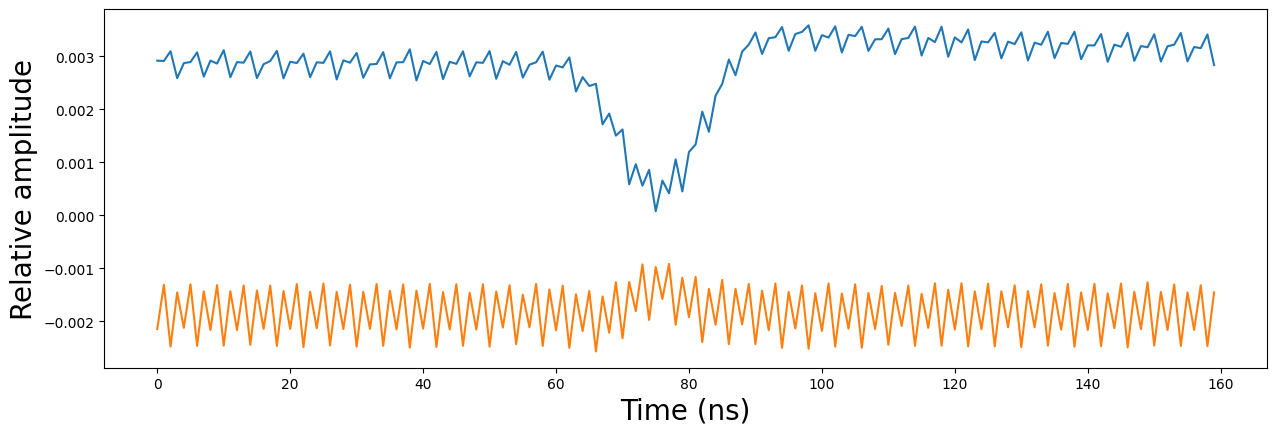

In [184]:
# Plot results.
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(np.array(avg_acq["avg"]["acquisition"]["scope"]["path0"]["data"][130:290]))
ax.plot(np.array(avg_acq["avg"]["acquisition"]["scope"]["path1"]["data"][130:290]))
ax.set_xlabel("Time (ns)", fontsize=20)
ax.set_ylabel("Relative amplitude", fontsize=20)
plt.show()

Note that the accumulated acquisitions have already been averaged when the data is returned. The instrument keeps track of the number of accumulations and divides the result upon returning the data. The number of accumulations is also available for review.

In [185]:
# Print number of averages
print(avg_acq["avg"]["acquisition"]["scope"]["path0"]["avg_cnt"])
print(avg_acq["avg"]["acquisition"]["scope"]["path1"]["avg_cnt"])

1000
1000


To show that the hardware averaging worked, let's compare and zoom in on the data from the very first acquisition in this tutorial and the very last.

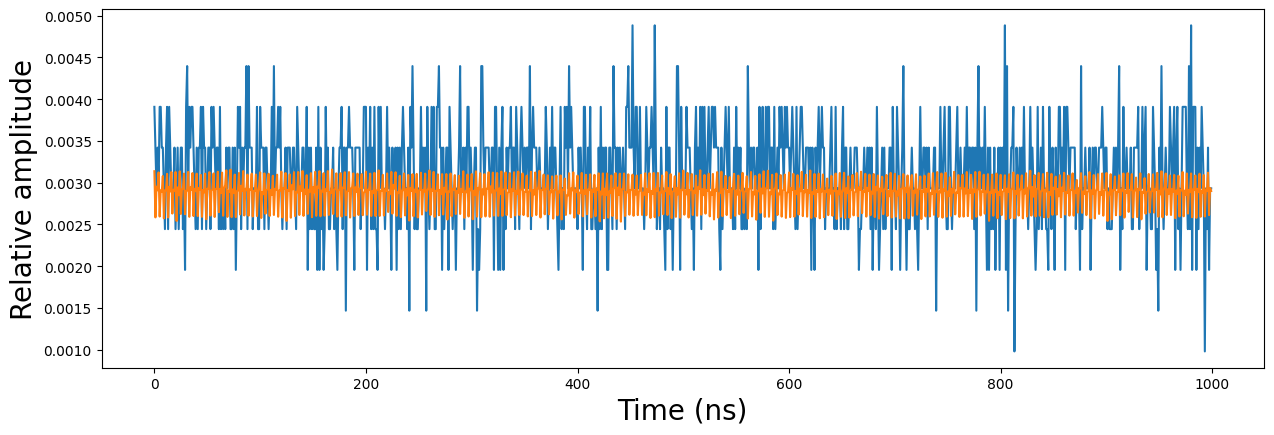

In [186]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(np.array(single_acq["single"]["acquisition"]["scope"]["path0"]["data"][1000:2000]))
ax.plot(np.array(avg_acq["avg"]["acquisition"]["scope"]["path0"]["data"][1000:2000]))
ax.set_xlabel("Time (ns)", fontsize=20)
ax.set_ylabel("Relative amplitude", fontsize=20)
plt.show()

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before 
closing the connection by uncommenting the corresponding lines. 

In [187]:
# Stop sequencer.
readout_module.stop_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_state(0))
print()

# Uncomment the following to print an overview of the instrument parameters.
# Print an overview of the instrument parameters.
# print("Snapshot:")
# readout_module.print_readable_snapshot(update=True)

# Reset the cluster
cluster.reset()
print(cluster.get_system_state())

Status: STOPPED, Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE

Status: OKAY, Flags: NONE, Slot flags: NONE
